<a href="https://colab.research.google.com/github/fidhaaysha/Brain-tumor-MRI-Image-classification/blob/main/BRAIN_TUMOR_MRI_IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import drive
import zipfile
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
import shutil
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


In [ ]:
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/brain_tumor_dataset'

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
#Path for training and testing dataset
train_path = os.path.join(extract_path, 'Training')
test_path = os.path.join(extract_path, 'Testing')

In [ ]:
#Function to count the number of images in each class folder
def count_images_in_folder(path):
    class_counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts
train_image_counts = count_images_in_folder(train_path)
test_image_counts = count_images_in_folder(test_path)

print("Training Set Image Counts:")
for class_name, count in train_image_counts.items():
    print(f"{class_name}: {count} images")

print("\nTesting Set Image Counts:")
for class_name, count in test_image_counts.items():
    print(f"{class_name}: {count} images")


Training Set Image Counts:
pituitary: 1457 images
meningioma: 1339 images
glioma: 1321 images
notumor: 1595 images

Testing Set Image Counts:
pituitary: 300 images
meningioma: 306 images
glioma: 300 images
notumor: 405 images


<ipython-input-7-006c12fcf51e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


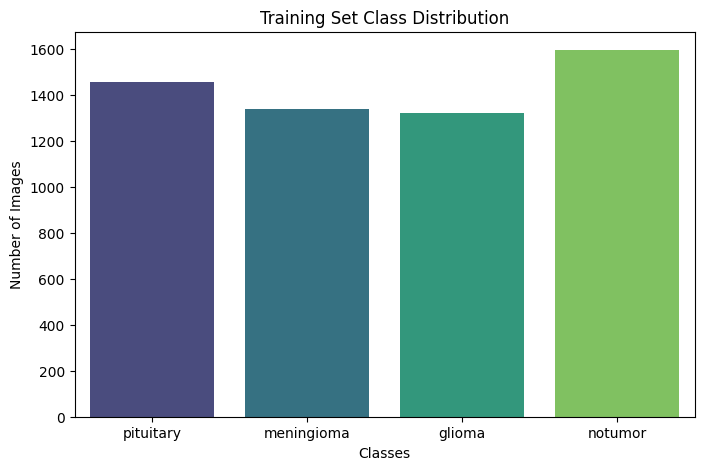

<ipython-input-7-006c12fcf51e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


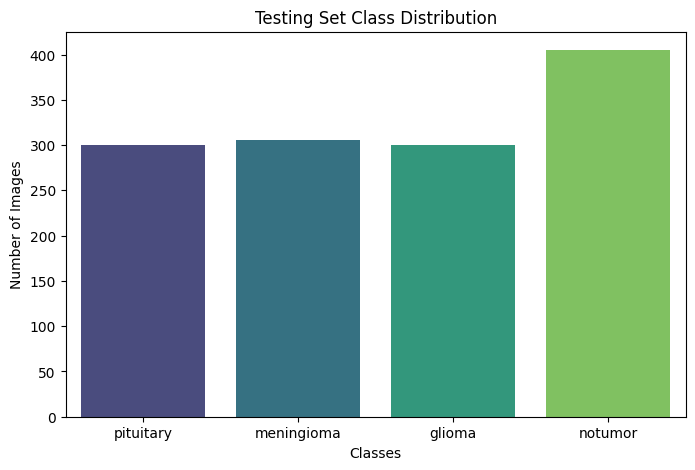

In [ ]:
#Function to plot the class distribution of images in a given dataset
def plot_class_distribution(path, title):
    class_counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title(f'{title} Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

# Plot for training and testing subsets
plot_class_distribution(train_path, 'Training Set')
plot_class_distribution(test_path, 'Testing Set')


In [ ]:
# Function to create a subset of image data
def create_subset(source_dir, dest_dir, num_samples_per_class):
    os.makedirs(dest_dir, exist_ok=True)
    for class_name in os.listdir(source_dir):
        source_class_dir = os.path.join(source_dir, class_name)
        dest_class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        samples = random.sample(os.listdir(source_class_dir), min(num_samples_per_class, len(os.listdir(source_class_dir))))
        for sample in samples:
            shutil.copy(os.path.join(source_class_dir, sample), os.path.join(dest_class_dir, sample))

train_subset_path = '/content/train_subset'
test_subset_path = '/content/test_subset'

create_subset(train_path, train_subset_path, 500)
create_subset(test_path, test_subset_path, 125)

In [ ]:
#Function to verify and display the number of images in each class
def verify_image_counts(path):
    for class_name in os.listdir(path):
        num_images = len(os.listdir(os.path.join(path, class_name)))
        print(f"{class_name}: {num_images} images")

print("Training Subset Image Counts:")
verify_image_counts(train_subset_path)

print("\nTesting Subset Image Counts:")
verify_image_counts(test_subset_path)


Training Subset Image Counts:
pituitary: 500 images
meningioma: 500 images
glioma: 500 images
notumor: 500 images

Testing Subset Image Counts:
pituitary: 125 images
meningioma: 125 images
glioma: 125 images
notumor: 125 images


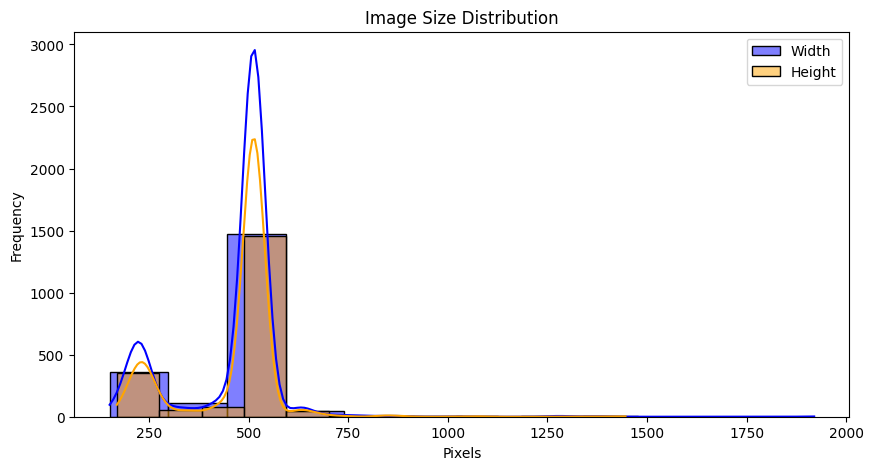

In [ ]:
#Function to visualize the distribution of image dimensions
def plot_image_size_distribution(path):
    image_sizes = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(10, 5))
    sns.histplot(widths, kde=True, color='blue', label='Width')
    sns.histplot(heights, kde=True, color='orange', label='Height')
    plt.title('Image Size Distribution')
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
plot_image_size_distribution(train_subset_path)

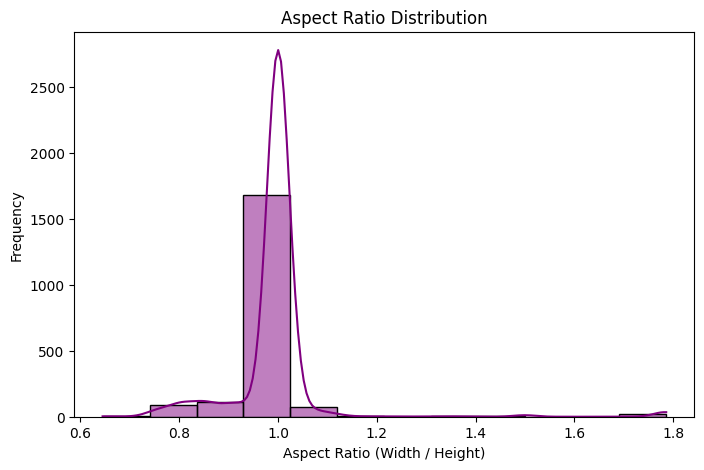

In [ ]:
#Function to visualize the distribution of image aspect ratios in a dataset
def plot_aspect_ratio_distribution(path):
    aspect_ratios = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                with Image.open(image_path) as img:
                    aspect_ratios.append(img.width / img.height)
    plt.figure(figsize=(8, 5))
    sns.histplot(aspect_ratios, kde=True, color='purple')
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width / Height)')
    plt.ylabel('Frequency')
    plt.show()

plot_aspect_ratio_distribution(train_subset_path)

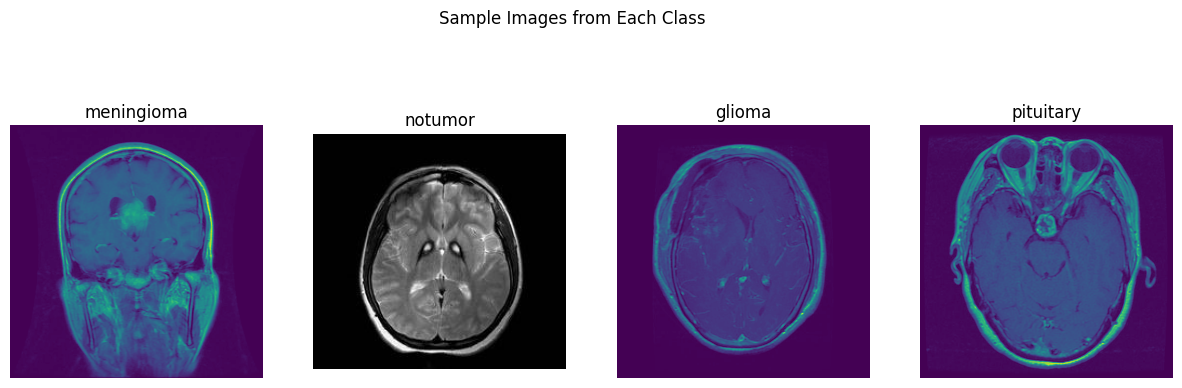

In [ ]:
#function to display sample images from each class
def show_sample_images(path):
    classes = os.listdir(path)
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        sample_image = os.path.join(class_path, os.listdir(class_path)[0])
        img = Image.open(sample_image)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(class_name)
    plt.suptitle("Sample Images from Each Class")
    plt.show()

show_sample_images(train_subset_path)

In [ ]:
# Data Preparation for Training and Validation
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_subset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_subset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2000 images belonging to 4 classes.
Found 500 images belonging to 4 classes.


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)
]

In [ ]:
#CNN Model Building
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

cnn_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train CNN Model
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 595ms/step - accuracy: 0.2875 - loss: 1.3860 - val_accuracy: 0.4240 - val_loss: 1.1957 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 418ms/step - accuracy: 0.4495 - loss: 1.1194 - val_accuracy: 0.4100 - val_loss: 1.2026 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 412ms/step - accuracy: 0.5466 - loss: 1.0338 - val_accuracy: 0.4620 - val_loss: 1.2626 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.5914 - loss: 0.9501 - val_accuracy: 0.5780 - val_loss: 1.0134 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 401ms/step - accuracy: 0.6242 - loss: 0.9090 - val_accuracy: 0.6640 - val_loss: 0.8171 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 407ms/step - accuracy: 0.6271 - loss: 0.8588 - val_accuracy: 0.5460 - val_loss: 1.1162 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - accuracy: 0.6571 - loss: 0.8205 - val_

In [ ]:
#evaluate model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(validation_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8944 - loss: 0.2875


In [ ]:
#save model
cnn_model.save('/content/cnn_model.keras')

In [ ]:
#load model
cnn_model = load_model('/content/cnn_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


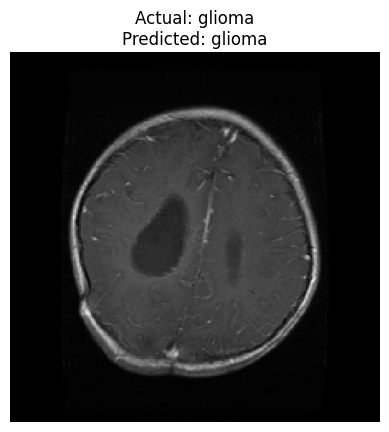

Actual Class: glioma
Predicted Class: glioma


In [ ]:
#Image Classification Prediction
img_path = '/content/test_subset/glioma/Te-gl_0018.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = cnn_model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=-1)

class_labels = ['glioma', 'meningioma', 'nontumor', 'pituitary']
predicted_class_label = class_labels[predicted_class_index[0]]

actual_class_label = img_path.split('/')[-2]

plt.imshow(img)
plt.title(f"Actual: {actual_class_label}\nPredicted: {predicted_class_label}")
plt.axis('off')
plt.show()
print(f"Actual Class: {actual_class_label}")
print(f"Predicted Class: {predicted_class_label}")

In [ ]:
#evaluate model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(validation_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8929 - loss: 0.3529


In [ ]:
y_true = validation_generator.classes
y_pred = cnn_model.predict(validation_generator, batch_size = batch_size)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step


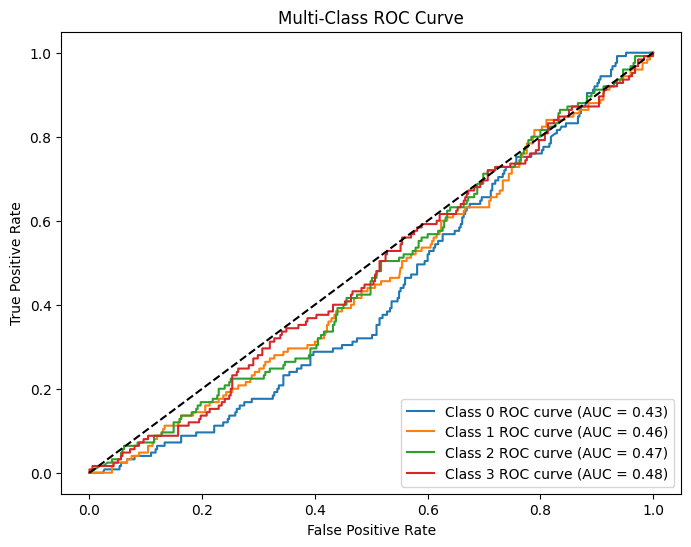

In [ ]:
# ROC Curve for Multi-Class
n_classes = validation_generator.num_classes  # Get number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#DenseNet model building
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

densenet_model = Model(inputs=base_model_densenet.input, outputs=output)
for layer in base_model_densenet.layers:
    layer.trainable = False

densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history_densenet = densenet_model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 883ms/step - accuracy: 0.4096 - loss: 1.7505 - val_accuracy: 0.7600 - val_loss: 0.6170
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 418ms/step - accuracy: 0.6604 - loss: 0.8214 - val_accuracy: 0.7780 - val_loss: 0.6350
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - accuracy: 0.6975 - loss: 0.7604 - val_accuracy: 0.7940 - val_loss: 0.5185
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.7190 - loss: 0.6808 - val_accuracy: 0.8260 - val_loss: 0.5559
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 412ms/step - accuracy: 0.7108 - loss: 0.6720 - val_accuracy: 0.7800 - val_loss: 0.5158
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 422ms/step - accuracy: 0.7528 - loss: 0.6213 - val_accuracy: 0.7560 - val_loss: 0.5631
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 415ms/step - accuracy: 0.7556 - loss: 0.6120 - val_accuracy: 0.7880 - val_loss: 0.4985
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 418ms/step - accuracy: 0.7657 - loss: 0.5888 - val_accu

In [ ]:
densenet_model.save('/content/densenet_model.keras')

In [ ]:
densenet_test_loss, densenet_test_acc = densenet_model.evaluate(validation_generator)
print(f"DenseNet Accuracy: {densenet_test_acc}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7729 - loss: 0.4649
DenseNet Accuracy: 0.8119999766349792


In [ ]:
y_pred = densenet_model.predict(validation_generator, verbose=1)
y_true = validation_generator.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


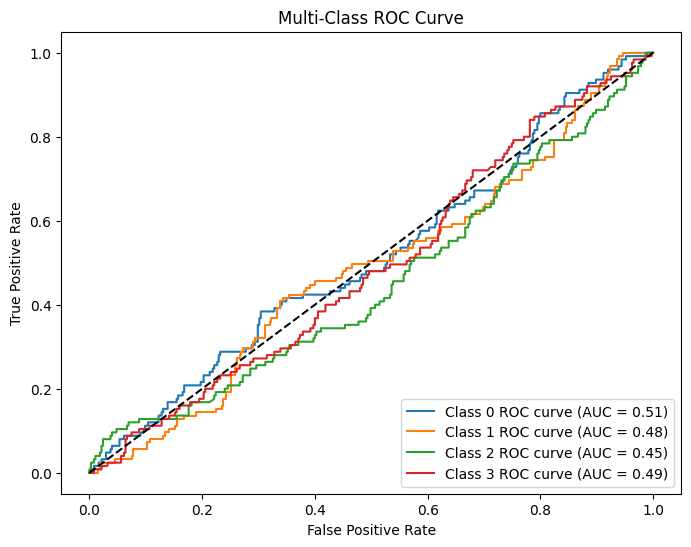

In [ ]:
n_classes = validation_generator.num_classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#Efficientnet model building
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

efficientnet_model = Model(inputs=base_model_efficientnet.input, outputs=output)
for layer in base_model_efficientnet.layers:
    layer.trainable = False

efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history_efficientnet = efficientnet_model.fit(train_generator, epochs=50, validation_data=validation_generator)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 799ms/step - accuracy: 0.2529 - loss: 1.3977 - val_accuracy: 0.2500 - val_loss: 1.3957
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.2613 - loss: 1.3966 - val_accuracy: 0.2500 - val_loss: 1.4024
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - accuracy: 0.2371 - loss: 1.4084 - val_accuracy: 0.2500 - val_loss: 1.3865
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 438ms/step - accuracy: 0.2636 - loss: 1.3911 - val_accuracy: 0.2500 - val_loss: 1.3866
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 0.2675 - loss: 1.3900 - val_accuracy: 0.2500 - val_loss: 1.3867
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 432ms/step - accuracy: 0.2649 - loss: 1.3899 - val_accuracy: 0.2500 - val_loss: 1.3866
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 413ms/step - accuracy: 0.2428 - loss: 1.3880 - val_accuracy: 0.2500 - val_loss: 1.3868
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.2293 - loss: 1.3890 - val_accu

In [ ]:
efficientnet_loss, efficientnet_acc = efficientnet_model.evaluate(validation_generator)
print(f"Loaded EfficientNet Model Accuracy: {efficientnet_acc}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.2388 - loss: 1.3864
Loaded EfficientNet Model Accuracy: 0.25


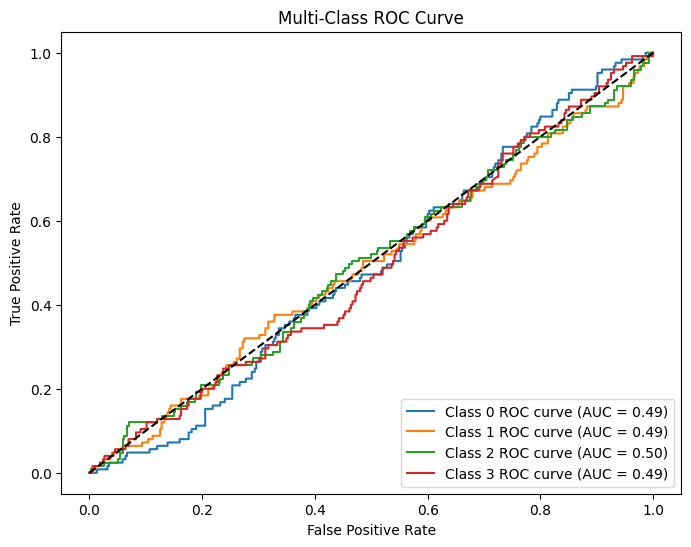

In [ ]:
n_classes = validation_generator.num_classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#Optimization
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

class_weights = {i: w * 1.5 for i, w in class_weights.items()}


optimized_cnn_model = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(0.001), input_shape=(224, 224, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(512, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(256, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
optimizer = RMSprop(learning_rate=0.0003)

optimized_cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_optimized_cnn = optimized_cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 415ms/step - accuracy: 0.5823 - loss: 2.6877 - val_accuracy: 0.2500 - val_loss: 5.3758
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - accuracy: 0.6595 - loss: 2.5708 - val_accuracy: 0.2500 - val_loss: 4.8500
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 413ms/step - accuracy: 0.6710 - loss: 2.4852 - val_accuracy: 0.2500 - val_loss: 4.4362
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 420ms/step - accuracy: 0.6727 - loss: 2.4038 - val_accuracy: 0.2520 - val_loss: 5.1610
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 412ms/step - accuracy: 0.7058 - loss: 2.2624 - val_accuracy: 0.2840 - val_loss: 5.3458
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 416ms/step - accuracy: 0.7204 - loss: 2.1667 - val_accuracy: 0.3440 - val_loss: 3.2904
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 413ms/step - accuracy: 0.7281 - loss: 2.0521 - val_accuracy: 0.4020 - val_loss: 2.8665
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 416ms/step - accuracy: 0.7347 - loss: 1.9959 - val_accu

In [ ]:
optimized_cnn_loss, optimized_cnn_acc = optimized_cnn_model.evaluate(validation_generator)
print(f"Final Optimized CNN Accuracy: {optimized_cnn_acc}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6180 - loss: 2.3131
Final Optimized CNN Accuracy: 0.6079999804496765


In [ ]:
optimized_cnn_model.save('/content/optimized_cnn_model.keras')

In [ ]:
optimized_cnn_model = load_model('optimized_cnn_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


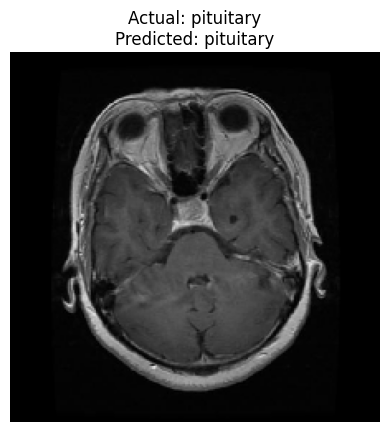

Actual Class: pituitary
Predicted Class: pituitary


In [ ]:
#optimized cnn prediction
img_path = '/content/test_subset/pituitary/Te-pi_0019.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


prediction = optimized_cnn_model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=-1)
class_labels = ['glioma', 'meningioma', 'nontumor', 'pituitary']
predicted_class_label = class_labels[predicted_class_index[0]]
actual_class_label = img_path.split('/')[-2]

plt.imshow(img)
plt.title(f"Actual: {actual_class_label}\nPredicted: {predicted_class_label}")
plt.axis('off')
plt.show()
print(f"Actual Class: {actual_class_label}")
print(f"Predicted Class: {predicted_class_label}")

In [ ]:
y_pred = optimized_cnn_model.predict(validation_generator, verbose=1)
y_true = validation_generator.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step


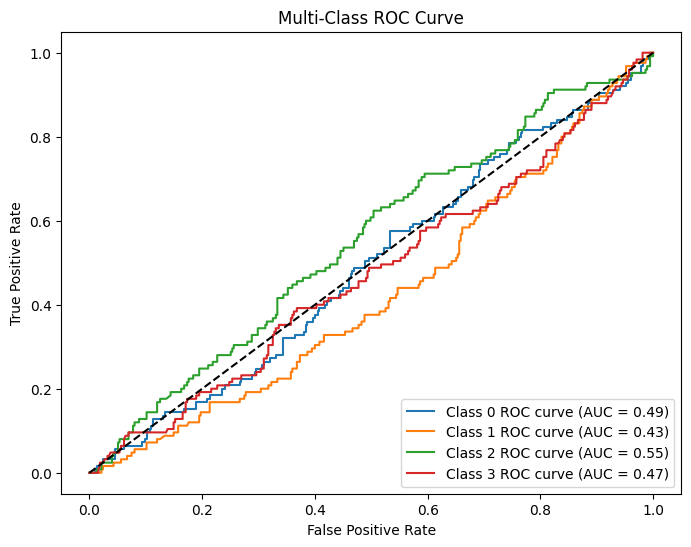

In [ ]:
#ROC curve for multiclass
n_classes = validation_generator.num_classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#Densenet tuning and optimization
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


U_base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = U_base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

U_densenet_model = Model(inputs=U_base_model_densenet.input, outputs=output)
for layer in U_base_model_densenet.layers:
    layer.trainable = False

U_densenet_model.compile(optimizer=RMSprop(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_densenet_model.keras', monitor='val_loss', save_best_only=True)
]


In [ ]:
for layer in U_base_model_densenet.layers[-50:]:
    layer.trainable = False

U_densenet_model.compile(optimizer=RMSprop(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
image_size = (224, 224)
batch_size = 32
validation_generator = test_datagen.flow_from_directory(
    test_subset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 500 images belonging to 4 classes.


In [ ]:
history_dense = U_densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.2587 - loss: 3.4241

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 841ms/step - accuracy: 0.2588 - loss: 3.4238 - val_accuracy: 0.2360 - val_loss: 2.5385
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 452ms/step - accuracy: 0.2650 - loss: 3.4160 - val_accuracy: 0.2680 - val_loss: 2.4710
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 522ms/step - accuracy: 0.2803 - loss: 3.2853 - val_accuracy: 0.2980 - val_loss: 2.4142
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 464ms/step - accuracy: 0.2919 - loss: 3.2943 - val_accuracy: 0.3680 - val_loss: 2.3677
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.2901 - loss: 3.2068 - val_accuracy: 0.4340 - val_loss: 2.3210
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 486ms/step - accuracy: 0.2834 - loss: 3.2343 - val_accuracy: 0.4720 - val_loss: 2.2721
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 464ms/step - accuracy: 0.3130 - loss: 3.1200 - val_accuracy: 0.4800 - val_loss: 2.2354
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 416ms/step - accuracy: 0.3120 - loss: 3.1060 - val_accuracy: 0.500

In [ ]:
densenet_loss, densenet_acc = U_densenet_model.evaluate(validation_generator)
print(f"Final Optimized CNN Accuracy: {densenet_acc}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7364 - loss: 1.6130
Final Optimized CNN Accuracy: 0.7139999866485596


In [ ]:
U_densenet_model.save('/content/U_densenet_model.keras')

In [ ]:
#Tuning and Optimization
U_base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = U_base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

U_efficientnet_model = Model(inputs=U_base_model_efficientnet.input, outputs=output)
for layer in U_base_model_efficientnet.layers:
    layer.trainable = False

U_efficientnet_model.compile(optimizer=RMSprop(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
optimized_cnn_model = load_model('/content/optimized_cnn_model.keras')

In [ ]:
# EfficientNet Model
history_efficientnet = U_efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 843ms/step - accuracy: 0.2628 - loss: 3.4346 - val_accuracy: 0.2500 - val_loss: 2.4703
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.2588 - loss: 3.4048 - val_accuracy: 0.2500 - val_loss: 2.4848
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.2506 - loss: 3.2114 - val_accuracy: 0.2500 - val_loss: 2.4941
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 366ms/step - accuracy: 0.2530 - loss: 3.1184 - val_accuracy: 0.2500 - val_loss: 2.4691
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 377ms/step - accuracy: 0.2422 - loss: 3.0934 - val_accuracy: 0.2500 - val_loss: 2.4401
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accuracy: 0.2663 - loss: 2.9786 - val_accuracy: 0.2500 - val_loss: 2.4054
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.2458 - loss: 2.8917 - val_accuracy: 0.2500 - val_loss: 2.3622
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 393ms/step - accuracy: 0.2362 - loss: 2.8711 - val_accuracy: 0.250

In [ ]:
efficientnet_loss, efficientnet_acc = U_efficientnet_model.evaluate(validation_generator)
print(f"Final Optimized CNN Accuracy: {efficientnet_acc}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2605 - loss: 1.6950
Final Optimized CNN Accuracy: 0.25


In [ ]:
U_efficientnet_model.save('/content/U_efficientnet_model.keras')